In [5]:

import os
import re
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
from openai import OpenAI
from anthropic import Anthropic
from items import Item
from testing import Tester

In [3]:
load_dotenv(override=True)
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN')
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')

In [4]:
hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [6]:
openai = OpenAI()


In [7]:
with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [8]:
fine_tune_train = train[:200]
fine_tune_validation = train[200:250]

In [9]:
def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": f"Price is ${item.price:.2f}"}
    ]

In [10]:
def make_jsonl(items):
    result = ""
    for item in items:
        messages = messages_for(item)
        messages_str = json.dumps(messages)
        result += '{"messages": ' + messages_str +'}\n'
    return result.strip()


In [11]:
def write_jsonl(items, filename):
    with open(filename, "w") as f:
        jsonl = make_jsonl(items)
        f.write(jsonl)

In [12]:
write_jsonl(fine_tune_train, "fine_tune_train.jsonl")


In [13]:
write_jsonl(fine_tune_validation, "fine_tune_validation.jsonl")


In [14]:
with open("fine_tune_train.jsonl", "rb") as f:
    train_file = openai.files.create(file=f, purpose="fine-tune")
with open("fine_tune_validation.jsonl", "rb") as f:
    validation_file = openai.files.create(file=f, purpose="fine-tune")

In [15]:
wandb_integration = {"type": "wandb", "wandb": {"project": "gpt-pricer"}}

In [16]:
openai.fine_tuning.jobs.create(
    training_file=train_file.id,
    validation_file=validation_file.id,
    model="gpt-4o-mini-2024-07-18",
    seed=42,
    hyperparameters={"n_epochs": 1},
    integrations = [wandb_integration],
    suffix="pricer"
)

FineTuningJob(id='ftjob-xWM8bcKvw4sfE1EuZpJrTnUI', created_at=1743876097, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-HLvlFWhrGq7PQjoYRgh2YE3X', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-B1efvYQD6ctr67fDy4ZvQy', validation_file='file-JUkrWiFndL234jbAUCxPux', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-xWM8bcKvw4sfE1EuZpJrTnUI'))], metadata=None, method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1)), type='supervised'), user_provided_suffix='pricer')

In [17]:
openai.fine_tuning.jobs.list(limit=1)


SyncCursorPage[FineTuningJob](data=[FineTuningJob(id='ftjob-xWM8bcKvw4sfE1EuZpJrTnUI', created_at=1743876097, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-HLvlFWhrGq7PQjoYRgh2YE3X', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-B1efvYQD6ctr67fDy4ZvQy', validation_file='file-JUkrWiFndL234jbAUCxPux', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-xWM8bcKvw4sfE1EuZpJrTnUI'))], metadata=None, method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1)), type='supervised'), user_

In [18]:
job_id = openai.fine_tuning.jobs.list(limit=1).data[0].id


In [26]:
openai.fine_tuning.jobs.list_events(fine_tuning_job_id=job_id, limit=10).data


[FineTuningJobEvent(id='ftevent-rpO4h0WkfewlwjOCBIIeL8R3', created_at=1743876736, level='info', message='The job has successfully completed', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-Z4iSxtaL3NDu02KgStUgrjH0', created_at=1743876731, level='info', message='New fine-tuned model created', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-DkywUwNYF4cQiRNhBckFv6bT', created_at=1743876666, level='info', message='Step 200/200: training loss=1.13, validation loss=1.11, full validation loss=1.12', object='fine_tuning.job.event', data={'step': 200, 'train_loss': 1.1326918601989746, 'valid_loss': 1.1092033386230469, 'total_steps': 200, 'full_valid_loss': 1.1151207828521728, 'train_mean_token_accuracy': 0.75, 'valid_mean_token_accuracy': 0.75, 'full_valid_mean_token_accuracy': 0.7925}, type='metrics'),
 FineTuningJobEvent(id='ftevent-e1RTlns4y2SKyKZAmeipq0wu', created_at=1743876660, level='info', message='Step

In [27]:
fine_tuned_model_name = openai.fine_tuning.jobs.retrieve(job_id).fine_tuned_model


In [28]:
def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [29]:
def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [30]:

get_price("The price is roughly $99.99 because blah blah")


99.99

In [31]:
def gpt_fine_tuned(item):
    response = openai.chat.completions.create(
        model=fine_tuned_model_name, 
        messages=messages_for(item),
        seed=42,
        max_tokens=7
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [32]:
print(test[0].price)
print(gpt_fine_tuned(test[0]))

374.41
490.0


1: Guess: $490.00 Truth: $374.41 Error: $115.59 SLE: 0.07 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $194.99 Truth: $225.11 Error: $30.12 SLE: 0.02 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $65.65 Truth: $61.68 Error: $3.97 SLE: 0.00 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $726.65 Truth: $599.99 Error: $126.66 SLE: 0.04 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $14.65 Truth: $16.99 Error: $2.34 SLE: 0.02 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $13.66 Truth: $31.99 Error: $18.33 SLE: 0.66 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $139.98 Truth: $101.79 Error: $38.19 SLE: 0.10 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $262.47 Truth: $289.00 Error: $26.53 SLE: 0.01 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $349.99 Truth: $635.86 Error: $285.87 SLE: 0.35 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $127.99 Truth: $65.99 Error: $62.00 SLE: 0.43 

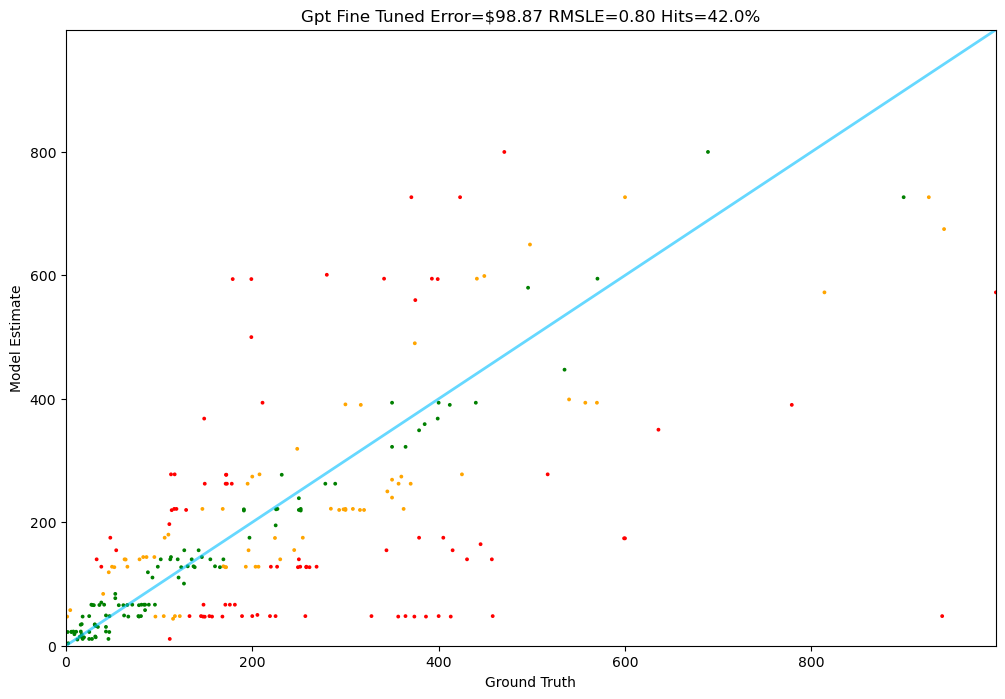

In [33]:
Tester.test(gpt_fine_tuned, test)